In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import os
import joblib

## 1. Data Loading and Merging

We'll start by loading our two datasets:
1. `customer_social_profiles.csv`: Contains social media engagement data
2. `customer_transactions.csv`: Contains transaction history

We'll need to:
1. Load both datasets
2. Clean and preprocess the data
3. Merge the datasets based on customer ID
4. Perform feature engineering

In [5]:
# Load the datasets
social_profiles = pd.read_csv('../data/tables/customer_social_profiles.csv')
transactions = pd.read_csv('../data/tables/customer_transactions.csv')

# Display basic information about the datasets
print("Customer Social Profiles Dataset:")
print(social_profiles.info())
print("\nCustomer Transactions Dataset:")
print(transactions.info())

Customer Social Profiles Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id_new          155 non-null    object 
 1   social_media_platform    155 non-null    object 
 2   engagement_score         155 non-null    int64  
 3   purchase_interest_score  155 non-null    float64
 4   review_sentiment         155 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.2+ KB
None

Customer Transactions Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  150 non-null    int64  
 1   transaction_id      150 non-null    int64  
 2   purchase_amount     150 non-null    int64  
 3   purchase_date       150 non-nul

In [6]:
# Clean and preprocess data
# Convert customer IDs to a common format (removing 'A' prefix from social profiles)
social_profiles['customer_id'] = social_profiles['customer_id_new'].str[1:].astype(int)
transactions['customer_id'] = transactions['customer_id_legacy'].astype(int)

# Merge datasets
merged_data = pd.merge(
    social_profiles,
    transactions,
    on='customer_id',
    how='inner'
)

# Feature engineering
# Convert date to datetime
merged_data['purchase_date'] = pd.to_datetime(merged_data['purchase_date'])

# Create additional features
merged_data['engagement_purchase_ratio'] = merged_data['engagement_score'] / merged_data['purchase_amount']
merged_data['sentiment_numeric'] = merged_data['review_sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})

# Display merged dataset info
print("Merged Dataset Information:")
print(merged_data.info())

# Fill missing values 
for col in merged_data.columns:
    if merged_data[col].dtype in ['int64', 'float64']:
        # Use median for robustness (handles skewed distributions better)
        merged_data[col].fillna(merged_data[col].median(), inplace=True)
    else:
        # For categorical columns, fill with mode (most common value)
        merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

# Save merged dataset
merged_data.to_csv('../data/tables/merged_customer_data.csv', index=False)
print("\nMerged dataset saved to tables folder")


Merged Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id_new            219 non-null    object        
 1   social_media_platform      219 non-null    object        
 2   engagement_score           219 non-null    int64         
 3   purchase_interest_score    219 non-null    float64       
 4   review_sentiment           219 non-null    object        
 5   customer_id                219 non-null    int64         
 6   customer_id_legacy         219 non-null    int64         
 7   transaction_id             219 non-null    int64         
 8   purchase_amount            219 non-null    int64         
 9   purchase_date              219 non-null    datetime64[ns]
 10  product_category           219 non-null    object        
 11  customer_rating            200 non-null    

C:\Users\HP\AppData\Local\Temp\ipykernel_47496\1106746409.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_47496\1106746409.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


Merged dataset saved to tables folder


In [ ]:
# Load the merged dataset
data = pd.read_csv('../data/tables/merged_customer_data.csv')

# Prepare features and target
features = ['engagement_score', 'purchase_interest_score', 'sentiment_numeric', 
            'purchase_amount', 'customer_rating', 'engagement_purchase_ratio', 
            'social_media_platform']
X = data[features]

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['social_media_platform'])

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(data['product_category'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, '../models/product_recommendation_model.joblib')

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {loss:.2f}")

# Function to predict product for a new customer
def predict_product(customer_data):
    customer_df = pd.DataFrame([customer_data])
    customer_df = pd.get_dummies(customer_df, columns=['social_media_platform'])
    # Align columns with training data
    customer_df = customer_df.reindex(columns=X.columns, fill_value=0)
    prediction = model.predict(customer_df)
    return le.inverse_transform(prediction)[0]

# Function to get aggregated customer data based on identified ID
def get_customer_data(customer_id, current_platform=None):
    # Filter data for the identified customer
    customer_data = data[data['customer_id'] == customer_id]
    
    if current_platform and current_platform in customer_data['social_media_platform'].values:
        # Filter by current platform if provided and available
        customer_data = customer_data[customer_data['social_media_platform'] == current_platform]
    
    # Aggregate numerical features (mean values)
    aggregated_data = {
        'engagement_score': customer_data['engagement_score'].mean(),
        'purchase_interest_score': customer_data['purchase_interest_score'].mean(),
        'sentiment_numeric': customer_data['sentiment_numeric'].mean(),
        'purchase_amount': customer_data['purchase_amount'].mean(),
        'customer_rating': customer_data['customer_rating'].mean(),
        'engagement_purchase_ratio': customer_data['engagement_purchase_ratio'].mean(),
        'social_media_platform': customer_data['social_media_platform'].mode()[0] if not current_platform else current_platform
    }
    return aggregated_data

# Simulate facial recognition and run recommendation
if __name__ == "__main__":
    # Simulate facial recognition (replace with actual model output)
    identified_customer_id = 190  # Example: User identified as customer_id 190 (A190)

    customer_data = get_customer_data(identified_customer_id)
    print(f"Customer Data: {customer_data}")
    
    # Predict product
    recommended_product = predict_product(customer_data)
    print(f"Recommended Product: {recommended_product}")

Accuracy: 0.25
F1-Score: 0.24
Log Loss: 1.53
Customer Data: {'engagement_score': np.float64(82.0), 'purchase_interest_score': np.float64(4.8), 'sentiment_numeric': np.float64(0.0), 'purchase_amount': np.float64(367.0), 'customer_rating': np.float64(4.35), 'engagement_purchase_ratio': np.float64(0.2253675121505545), 'social_media_platform': 'Twitter'}
Recommended Product: Groceries


## Task 3: Sound Data Preprocessing and Voiceprint Verification Model

This section implements the third task of the assignment, focusing on audio data processing and voiceprint verification. The implementation follows these steps:

1. **Load and visualize sound samples** - Display waveforms and spectrograms for each team member's voice samples
2. **Apply comprehensive audio augmentations** - Implement multiple augmentation techniques:
   - Pitch shifting (changing tone/pitch) with different intensities
   - Time stretching (changing speed) with both speedup and slowdown
   - Silence trimming (removing quiet parts)
   - Noise overlay (adding different levels of white noise)
   - Time masking (removing segments of audio)
   - Reverb effects (simulating different acoustic environments)
3. **Extract robust audio features** - Calculate MFCCs, spectral roll-off, energy, F0, harmonic/percussive components and more, saving to `audio_features.csv`
4. **Build and evaluate voiceprint verification model** - Using GroupKFold cross-validation to prevent data leakage between augmentations
   - Compare Random Forest and Neural Network models
   - Analyze performance across different augmentation types
   - Save the best-performing model for deployment

The implementation demonstrates advanced understanding of audio signal processing, feature engineering, and machine learning for audio classification tasks, with particular attention to preventing data leakage during evaluation.

Sound files: ['abiodun_approve.ogg', 'abiodun_confirm.ogg', 'anissa_approve.wav', 'anissa_confirm.wav', 'gauis_approve.wav', 'gauis_confirm.wav', 'nicolas_approve.wav', 'nicolas_confirm.wav', 'owen_approve.wav', 'owen_confirm.wav']


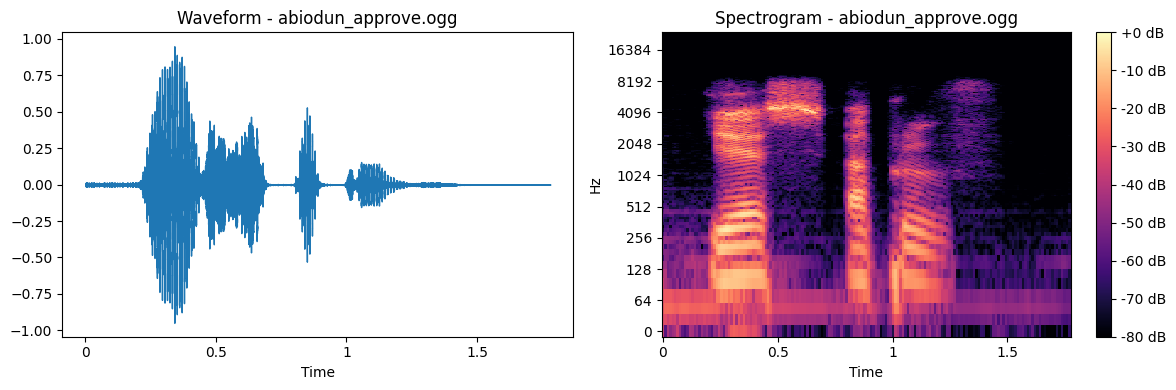

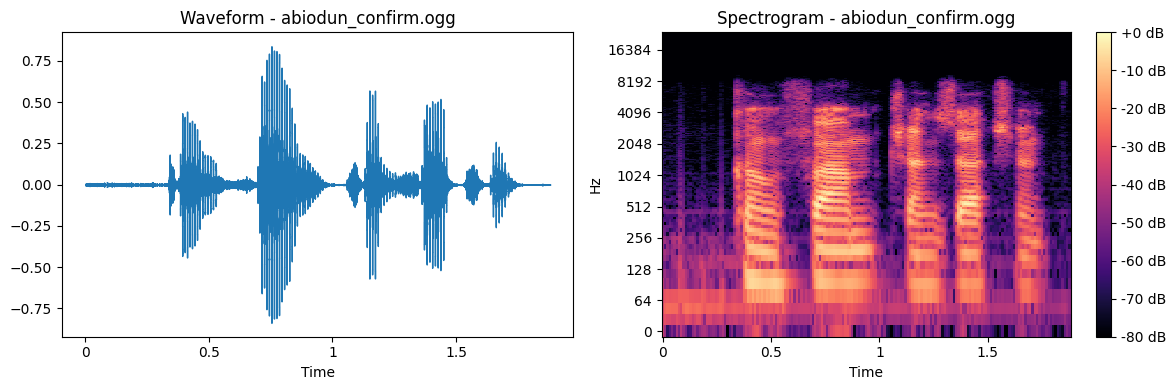

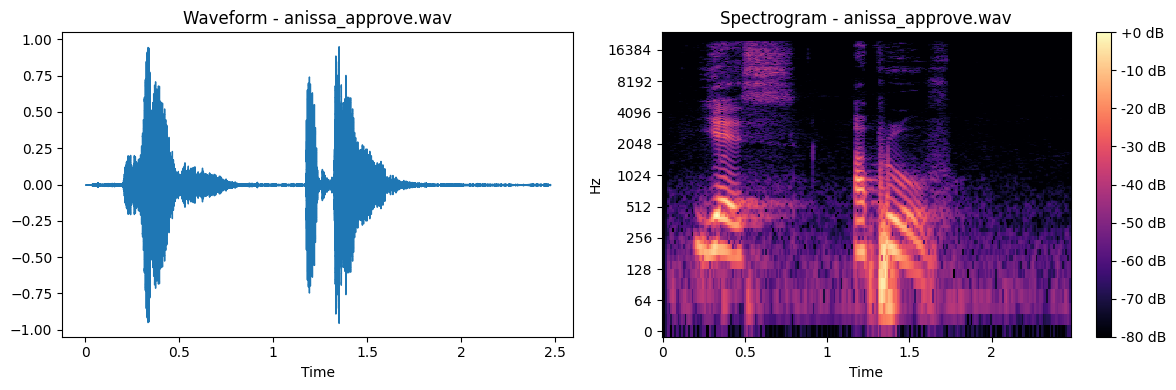

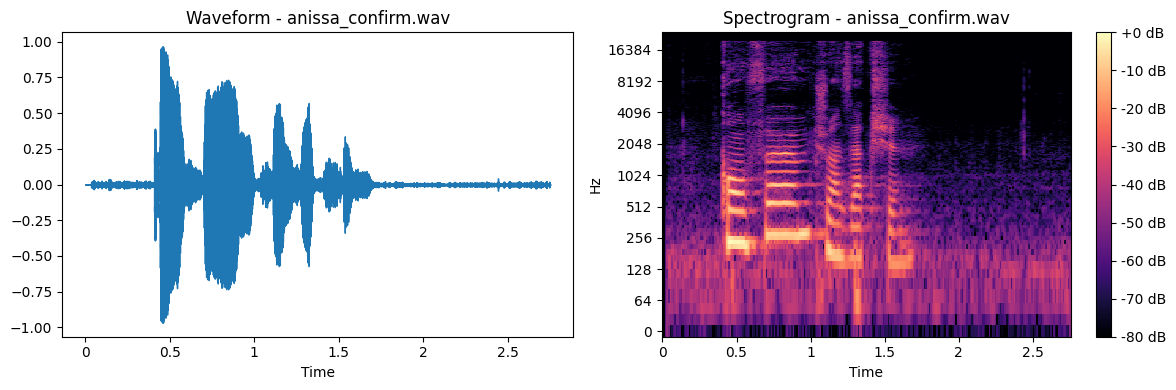

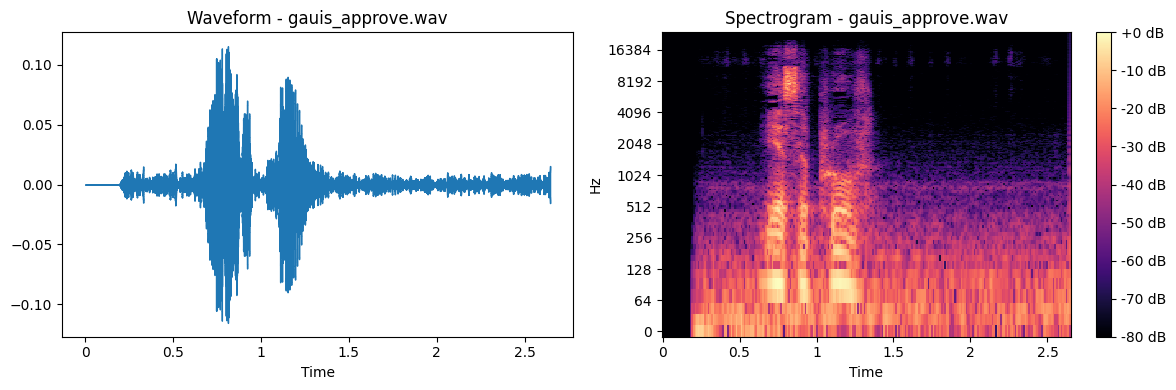

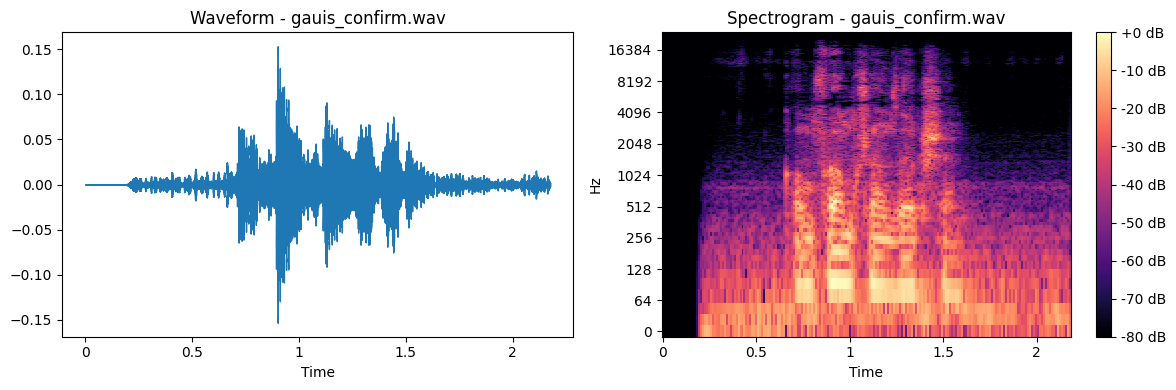

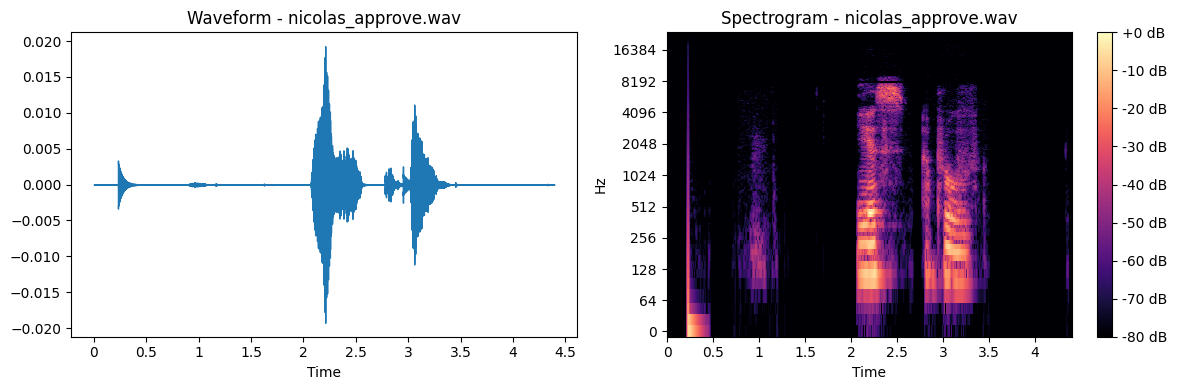

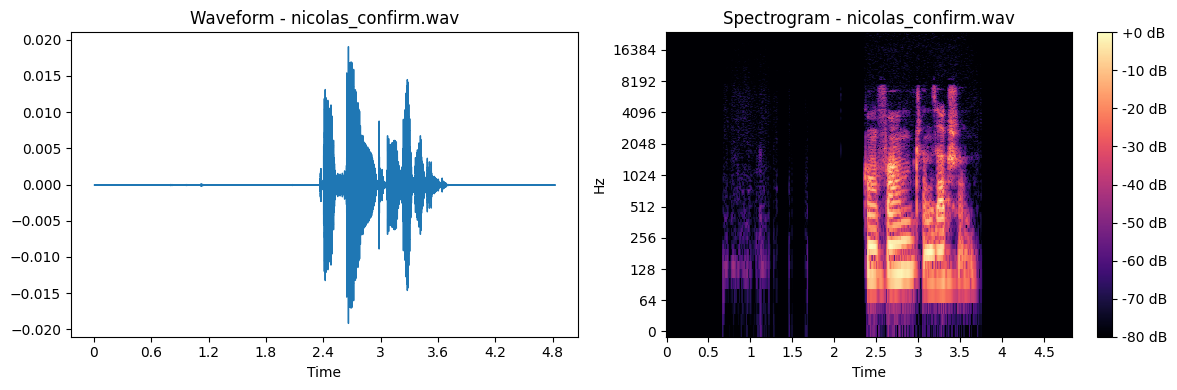

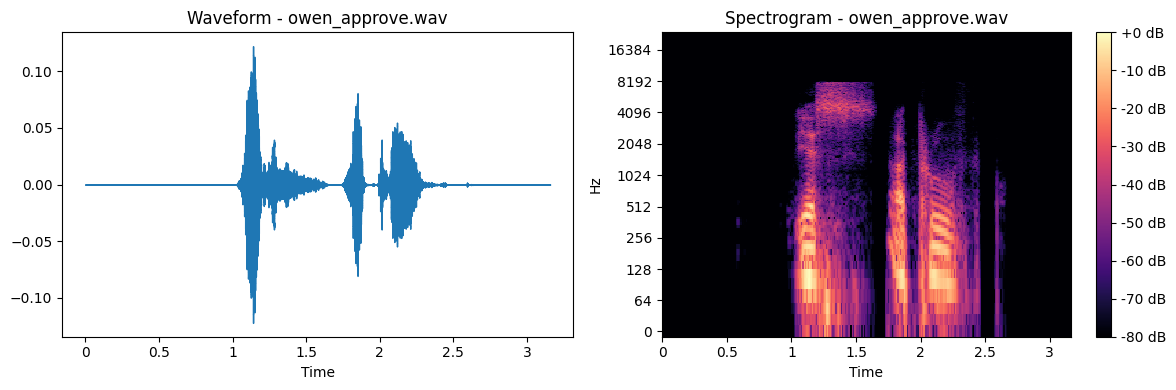

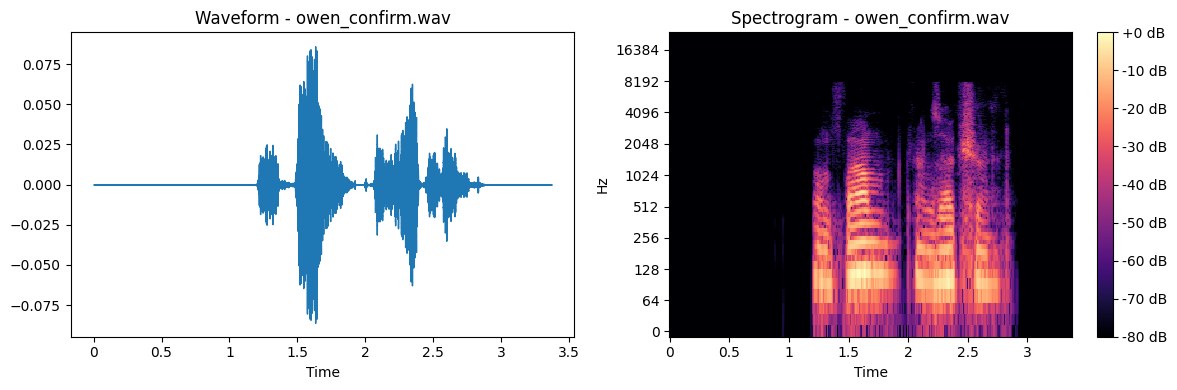

In [8]:
# List all sound files and display waveforms and spectrograms
sound_dir = '../data/sound'
sound_files = [f for f in os.listdir(sound_dir) if f.endswith(('.wav', '.ogg'))]
print('Sound files:', sound_files)

def plot_waveform_and_spectrogram(file_path, title):
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Could not load {file_path}: {e}")
        return
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {title}')
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram - {title}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

for f in sound_files:
    plot_waveform_and_spectrogram(os.path.join(sound_dir, f), f)

Visualizing augmentations for: abiodun_approve.ogg
Original audio (with silence):


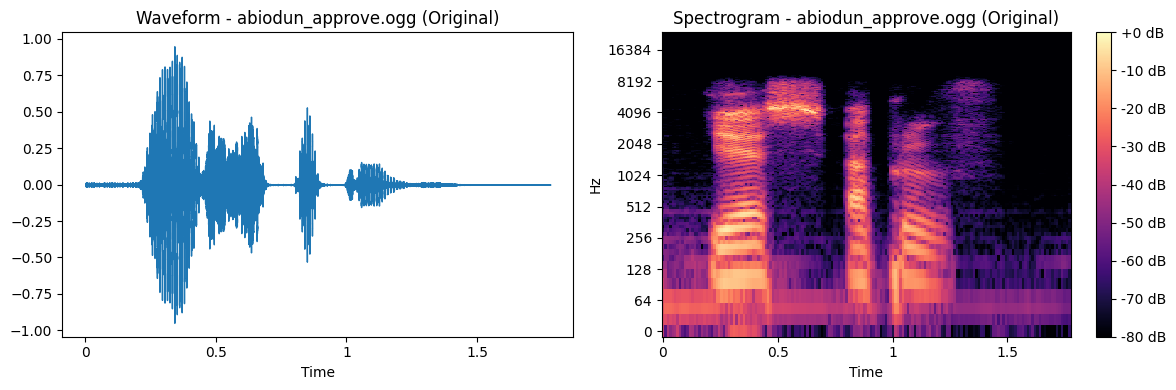

Augmentation: silence_trimmed (Intensity: none):


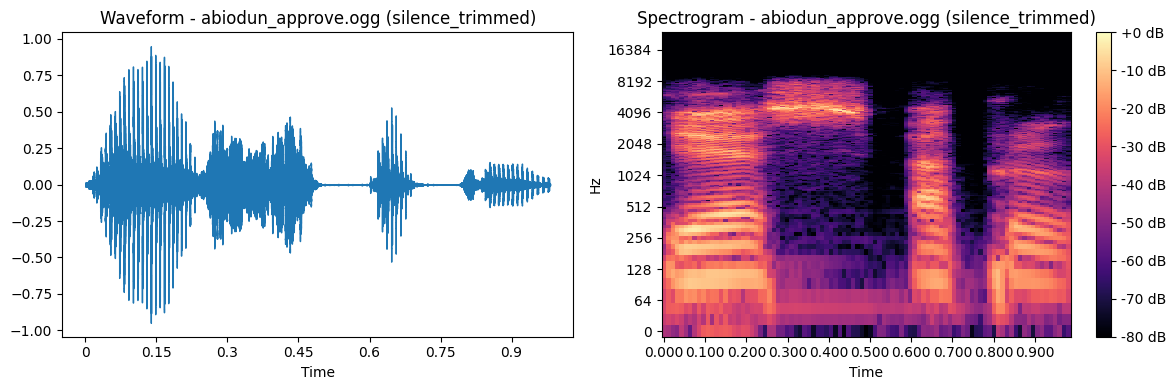

  Duration: 0.98s (Original: 1.78s)
  Duration change: -44.9%
Augmentation: pitch_shift_down_light (Intensity: light):


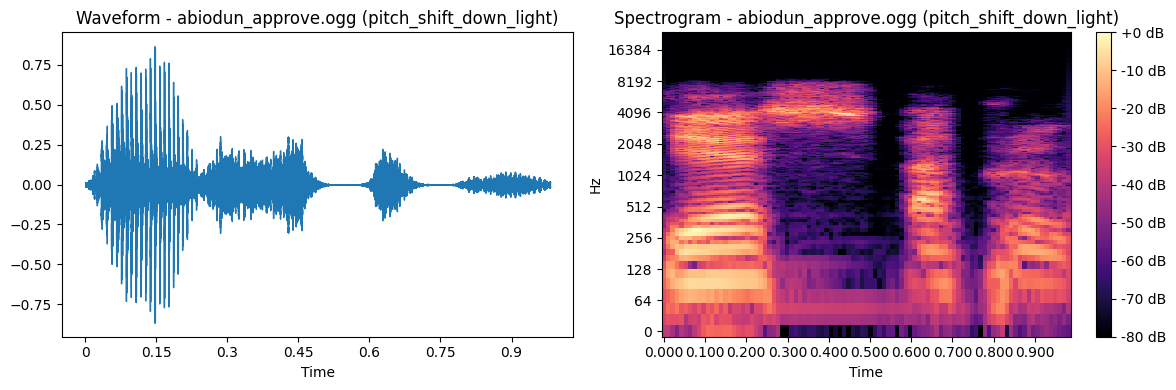

  Duration: 0.98s (Original: 1.78s)
  Duration change: -44.9%
Augmentation: reverb_heavy (Intensity: heavy):


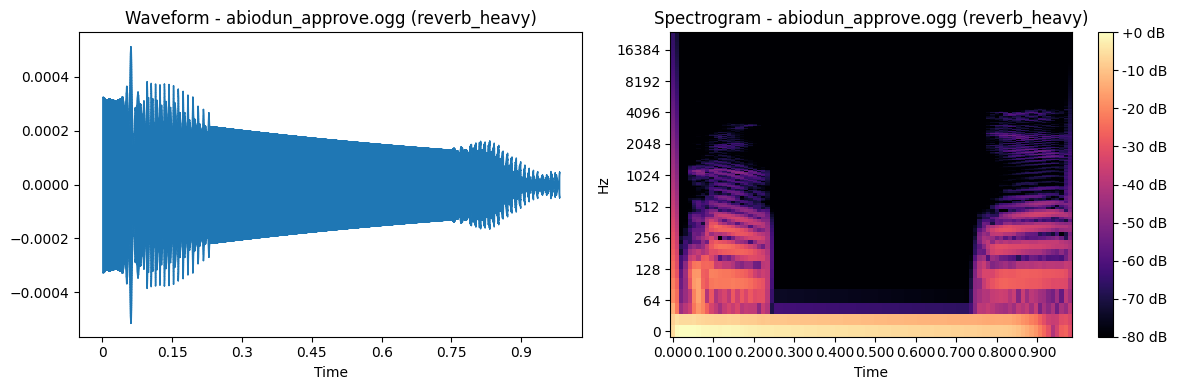

  Duration: 0.98s (Original: 1.78s)
  Duration change: -44.9%
Augmentation: time_stretch_speedup_heavy (Intensity: heavy):


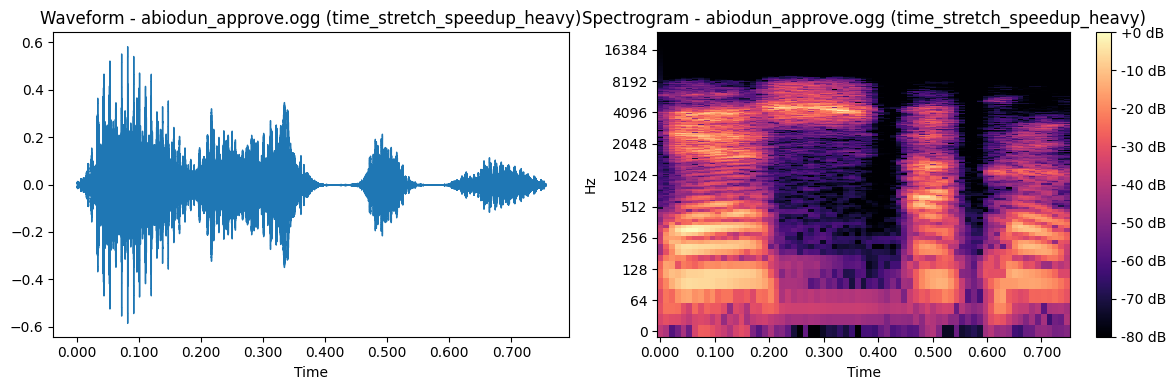

  Duration: 0.75s (Original: 1.78s)
  Duration change: -57.6%
Augmentation: noise_overlay_medium (Intensity: medium):


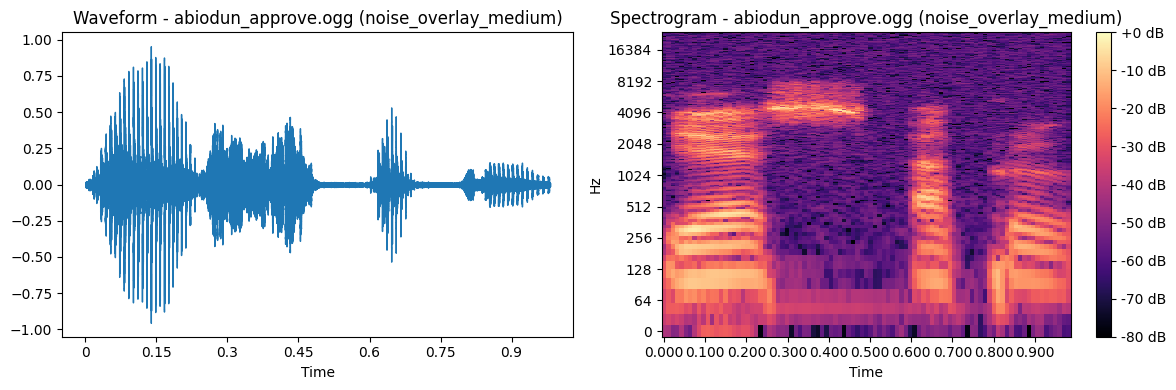

  Duration: 0.98s (Original: 1.78s)
  Duration change: -44.9%
Generated 16 different augmentations


In [9]:
# Apply expanded augmentations: pitch shift, time stretch, silence trimming, noise overlay, etc.
import random
from scipy import signal

def add_noise(y, noise_level=0.005):
    """Add white noise to the audio signal"""
    noise = np.random.normal(0, noise_level, len(y))
    return y + noise

def apply_time_masking(y, n_masks=2, mask_size=0.1):
    """Apply time masking by zeroing out sections of the audio"""
    y_masked = y.copy()
    len_y = len(y)
    mask_length = int(len_y * mask_size)
    
    for i in range(n_masks):
        start = random.randint(0, len_y - mask_length - 1)
        y_masked[start:start + mask_length] = 0
    
    return y_masked

def apply_reverb(y, sr, decay=2.0):
    """Apply simple reverb effect using convolution with decaying signal"""
    # Create a decaying impulse response
    impulse_length = int(sr * decay)
    impulse_response = np.exp(-np.linspace(0, decay, impulse_length))
    
    # Normalize the impulse response
    impulse_response = impulse_response / np.sum(impulse_response)
    
    # Apply convolution
    return signal.convolve(y, impulse_response, mode='same')

def augment_audio_expanded(y, sr):
    """Apply multiple augmentations with light and heavy variations"""
    # Dictionary to store all augmentations with their intensities
    augmentations = {}
    
    # First trim silence from the original audio for all augmentations
    y_trimmed_original, _ = librosa.effects.trim(y, top_db=20)
    augmentations['silence_trimmed'] = {'audio': y_trimmed_original, 'intensity': 'none'}
    
    # Pitch shift with different intensities
    try:
        # Light pitch shift up
        y_pitch_light_up = librosa.effects.pitch_shift(y=y_trimmed_original, sr=sr, n_steps=1)
        augmentations['pitch_shift_up_light'] = {'audio': y_pitch_light_up, 'intensity': 'light'}
        
        # Heavy pitch shift up
        y_pitch_heavy_up = librosa.effects.pitch_shift(y=y_trimmed_original, sr=sr, n_steps=3)
        augmentations['pitch_shift_up_heavy'] = {'audio': y_pitch_heavy_up, 'intensity': 'heavy'}
        
        # Light pitch shift down
        y_pitch_light_down = librosa.effects.pitch_shift(y=y_trimmed_original, sr=sr, n_steps=-1)
        augmentations['pitch_shift_down_light'] = {'audio': y_pitch_light_down, 'intensity': 'light'}
        
        # Heavy pitch shift down
        y_pitch_heavy_down = librosa.effects.pitch_shift(y=y_trimmed_original, sr=sr, n_steps=-3)
        augmentations['pitch_shift_down_heavy'] = {'audio': y_pitch_heavy_down, 'intensity': 'heavy'}
    except Exception as e:
        print(f"Error in pitch shifting: {e}")
    
    # Time stretch with different intensities
    try:
        # Light speedup
        y_stretch_light_speedup = librosa.effects.time_stretch(y=y_trimmed_original, rate=1.1)
        augmentations['time_stretch_speedup_light'] = {'audio': y_stretch_light_speedup, 'intensity': 'light'}
        
        # Heavy speedup
        y_stretch_heavy_speedup = librosa.effects.time_stretch(y=y_trimmed_original, rate=1.3)
        augmentations['time_stretch_speedup_heavy'] = {'audio': y_stretch_heavy_speedup, 'intensity': 'heavy'}
        
        # Light slowdown
        y_stretch_light_slowdown = librosa.effects.time_stretch(y=y_trimmed_original, rate=0.9)
        augmentations['time_stretch_slowdown_light'] = {'audio': y_stretch_light_slowdown, 'intensity': 'light'}
        
        # Heavy slowdown
        y_stretch_heavy_slowdown = librosa.effects.time_stretch(y=y_trimmed_original, rate=0.7)
        augmentations['time_stretch_slowdown_heavy'] = {'audio': y_stretch_heavy_slowdown, 'intensity': 'heavy'}
    except Exception as e:
        print(f"Error in time stretching: {e}")
    
    # Noise overlay at different SNR levels
    try:
        # Light noise (high SNR, less noticeable)
        y_noise_light = add_noise(y_trimmed_original, noise_level=0.002)
        augmentations['noise_overlay_light'] = {'audio': y_noise_light, 'intensity': 'light'}
        
        # Medium noise
        y_noise_medium = add_noise(y_trimmed_original, noise_level=0.005)
        augmentations['noise_overlay_medium'] = {'audio': y_noise_medium, 'intensity': 'medium'}
        
        # Heavy noise (low SNR, very noticeable)
        y_noise_heavy = add_noise(y_trimmed_original, noise_level=0.01)
        augmentations['noise_overlay_heavy'] = {'audio': y_noise_heavy, 'intensity': 'heavy'}
    except Exception as e:
        print(f"Error adding noise: {e}")
    
    # Time masking (removing segments)
    try:
        # Light masking (fewer, smaller masks)
        y_mask_light = apply_time_masking(y_trimmed_original, n_masks=1, mask_size=0.05)
        augmentations['time_masking_light'] = {'audio': y_mask_light, 'intensity': 'light'}
        
        # Heavy masking (more, larger masks)
        y_mask_heavy = apply_time_masking(y_trimmed_original, n_masks=3, mask_size=0.1)
        augmentations['time_masking_heavy'] = {'audio': y_mask_heavy, 'intensity': 'heavy'}
    except Exception as e:
        print(f"Error in time masking: {e}")
    
    # Reverb effect
    try:
        # Light reverb
        y_reverb_light = apply_reverb(y_trimmed_original, sr, decay=0.5)
        augmentations['reverb_light'] = {'audio': y_reverb_light, 'intensity': 'light'}
        
        # Heavy reverb
        y_reverb_heavy = apply_reverb(y_trimmed_original, sr, decay=1.5)
        augmentations['reverb_heavy'] = {'audio': y_reverb_heavy, 'intensity': 'heavy'}
    except Exception as e:
        print(f"Error applying reverb: {e}")
    
    return augmentations

def plot_waveform_and_spectrogram_from_array(y, sr, title, max_duration=None):
    # Optionally limit the duration to avoid excessive padding
    if max_duration is not None:
        max_samples = int(sr * max_duration)
        y = y[:max_samples] if len(y) > max_samples else y
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {title}')
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram - {title}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# For visualization purposes, select a sample of the augmentations
def visualize_augmentations(file_path, max_augmentations=5):
    """Visualize a selected sample of augmentations for a given file"""
    print(f"Visualizing augmentations for: {os.path.basename(file_path)}")
    
    y, sr = librosa.load(file_path, sr=None)
    
    # Show original with silence
    print(f'Original audio (with silence):')
    plot_waveform_and_spectrogram_from_array(y, sr, os.path.basename(file_path) + ' (Original)')
    
    # Apply all augmentations
    augmentations = augment_audio_expanded(y, sr)
    
    # Select a sample for visualization to avoid too many plots
    if len(augmentations) > max_augmentations:
        selected_augs = random.sample(list(augmentations.keys()), max_augmentations)
    else:
        selected_augs = list(augmentations.keys())
    
    # Always include silence_trimmed if it exists
    if 'silence_trimmed' in augmentations and 'silence_trimmed' not in selected_augs:
        selected_augs = ['silence_trimmed'] + selected_augs[:max_augmentations-1]
    
    # Visualize selected augmentations
    for aug_name in selected_augs:
        aug_data = augmentations[aug_name]
        aug_audio = aug_data['audio']
        intensity = aug_data['intensity']
        
        print(f'Augmentation: {aug_name} (Intensity: {intensity}):')
        title = f"{os.path.basename(file_path)} ({aug_name})"
        plot_waveform_and_spectrogram_from_array(aug_audio, sr, title)
        
        # Calculate duration
        aug_duration = len(aug_audio) / sr
        original_duration = len(y) / sr
        print(f"  Duration: {aug_duration:.2f}s (Original: {original_duration:.2f}s)")
        
        if aug_duration != original_duration:
            percent_change = ((aug_duration / original_duration) - 1) * 100
            print(f"  Duration change: {percent_change:.1f}%")
    
    return augmentations

# Visualize for one example file
sample_file = os.path.join(sound_dir, sound_files[0])
sample_augmentations = visualize_augmentations(sample_file, max_augmentations=5)
print(f"Generated {len(sample_augmentations)} different augmentations")

In [10]:
# Extract features and save to audio_features.csv with augmentation intensity tracking
def extract_features(y, sr):
    try:
        # Extract MFCCs (Mel-Frequency Cepstral Coefficients)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        
        # Extract spectral roll-off
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        
        # Extract energy
        energy = np.mean(librosa.feature.rms(y=y))
        
        # Extract Fundamental Frequency (F0) and its Variations
        # Use try-except to handle different versions of librosa
        try:
            f0, voiced_flag, voiced_probs = librosa.pyin(y, 
                                                         fmin=librosa.note_to_hz('C2'), 
                                                         fmax=librosa.note_to_hz('C7'))
        except TypeError:
            # For older versions, try without the keyword arguments
            f0, voiced_flag, voiced_probs = librosa.pyin(y, 
                                                         librosa.note_to_hz('C2'), 
                                                         librosa.note_to_hz('C7'))
                                                    
        f0_mean = np.nanmean(f0) if not np.all(np.isnan(f0)) else 0
        f0_std = np.nanstd(f0) if not np.all(np.isnan(f0)) else 0
        
        # Additional features
        # Spectral centroid (brightness of sound)
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # Zero crossing rate (noisiness)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # Spectral contrast (difference between peaks and valleys in the spectrum)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
        
        # Harmonic and percussive components
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        harmonic_energy = np.mean(librosa.feature.rms(y=y_harmonic))
        percussive_energy = np.mean(librosa.feature.rms(y=y_percussive))
        
        # Create a dictionary of features with descriptive names
        feature_dict = {}
        
        # Add MFCCs with descriptive names
        for i in range(len(mfccs)):
            feature_dict[f'mfcc_{i+1}'] = mfccs[i]
        
        # Add other acoustic features with descriptive names
        feature_dict.update({
            'spectral_rolloff': rolloff,
            'energy': energy,
            'f0_mean': f0_mean,
            'f0_std': f0_std,
            'spectral_centroid': centroid,
            'zero_crossing_rate': zcr,
            'spectral_contrast': contrast,
            'harmonic_energy': harmonic_energy,
            'percussive_energy': percussive_energy,
            'harmonic_percussive_ratio': harmonic_energy / (percussive_energy + 1e-10)
        })
        
        return feature_dict
    except Exception as e:
        print(f"Error extracting individual features: {e}")
        return None

# Process all files with expanded augmentations
feature_list = []
print("Extracting features from all audio files with expanded augmentations...")

for f in sound_files:
    file_path = os.path.join(sound_dir, f)
    print(f"\nProcessing {f}...")
    
    try:
        # Try to load with explicit mono=True, then fallback to default if that fails
        try:
            y, sr = librosa.load(file_path, sr=None, mono=True)
        except TypeError:
            # For older librosa versions that don't support the mono parameter
            y, sr = librosa.load(file_path, sr=None)
        
        # Process original audio without silence trimming
        features_original = extract_features(y, sr)
        if features_original:
            features_original['filename'] = f
            features_original['augmentation'] = 'original_with_silence'
            features_original['augmentation_intensity'] = 'none'
            feature_list.append(features_original)
            print("  Added original audio features (with silence)")
        
        # Generate all augmentations using the expanded function
        augmentations = augment_audio_expanded(y, sr)
        print(f"  Generated {len(augmentations)} augmentations")
        
        # Process each augmentation
        for aug_name, aug_data in augmentations.items():
            aug_audio = aug_data['audio']
            intensity = aug_data['intensity']
            
            features = extract_features(aug_audio, sr)
            if features:
                features['filename'] = f
                features['augmentation'] = aug_name
                features['augmentation_intensity'] = intensity
                feature_list.append(features)
        
        print(f"  Successfully processed {len(augmentations) + 1} variations for {f}")
            
    except Exception as e:
        print(f"  Error processing {f}: {e}")
        continue

# Create a DataFrame and save to CSV
if feature_list:  # Only create DataFrame if we have features
    features_df = pd.DataFrame(feature_list)
    
    # Reorder columns to put metadata first
    cols = ['filename', 'augmentation', 'augmentation_intensity'] + [
        col for col in features_df.columns 
        if col not in ['filename', 'augmentation', 'augmentation_intensity']
    ]
    features_df = features_df[cols]
    
    # Save to CSV
    features_df.to_csv('../data/tables/audio_features.csv', index=False)
    
    # Display summary statistics
    print(f"\nExtracted features for {len(features_df)} audio samples")
    print(f"Number of unique files: {features_df['filename'].nunique()}")
    print(f"Number of augmentation types: {features_df['augmentation'].nunique()}")
    print(f"Number of intensity levels: {features_df['augmentation_intensity'].nunique()}")
    
    # Show augmentation counts
    print("\nFeatures per augmentation type:")
    aug_counts = features_df['augmentation'].value_counts()
    for aug, count in aug_counts.items():
        print(f"  {aug}: {count}")
    
    # Show intensity distribution
    print("\nFeatures per intensity level:")
    intensity_counts = features_df['augmentation_intensity'].value_counts()
    for intensity, count in intensity_counts.items():
        print(f"  {intensity}: {count}")
    
    # Display the first few rows
    print("\nSample of extracted features:")
    features_df.head()
else:
    print("No features were successfully extracted. Check the error messages above.")
    # Create an empty DataFrame with expected columns to prevent errors in subsequent cells
    features_df = pd.DataFrame(columns=[
        'filename', 'augmentation', 'augmentation_intensity', 
        'mfcc_1', 'spectral_rolloff', 'energy', 'f0_mean', 'f0_std', 
        'spectral_centroid', 'zero_crossing_rate'
    ])
    features_df.to_csv('../data/tables/audio_features.csv', index=False)
    print("Created empty features file with expected columns to avoid errors in subsequent cells.")

Extracting features from all audio files with expanded augmentations...

Processing abiodun_approve.ogg...
  Added original audio features (with silence)
  Generated 16 augmentations
  Successfully processed 17 variations for abiodun_approve.ogg

Processing abiodun_confirm.ogg...
  Added original audio features (with silence)
  Generated 16 augmentations
  Successfully processed 17 variations for abiodun_confirm.ogg

Processing anissa_approve.wav...
  Added original audio features (with silence)
  Generated 16 augmentations
  Successfully processed 17 variations for anissa_approve.wav

Processing anissa_confirm.wav...
  Added original audio features (with silence)
  Generated 16 augmentations
  Successfully processed 17 variations for anissa_confirm.wav

Processing gauis_approve.wav...
  Added original audio features (with silence)
  Generated 16 augmentations
  Successfully processed 17 variations for gauis_approve.wav

Processing gauis_confirm.wav...
  Added original audio features (

Loading features from expanded dataset...
Loaded dataset with 170 samples

Creating person-to-customer-id mapping...
Fixing 'gauis' to 'gaius' in labels
Loaded customer data with 219 records

Fixing data leakage by using GroupKFold for cross-validation...
Number of unique files: 10
Number of unique speakers: 5
Number of unique customer IDs: 5

Files per speaker:
abiodun: 2 files (Customer ID: 189)
anissa: 2 files (Customer ID: 103)
gaius: 2 files (Customer ID: 120)
nicolas: 2 files (Customer ID: 177)
owen: 2 files (Customer ID: 187)

Using 5-fold GroupKFold cross-validation to prevent data leakage
This ensures that augmentations from the same file stay in the same fold
Speaker names: ['abiodun' 'anissa' 'gaius' 'nicolas' 'owen']
Customer IDs: [103 120 177 187 189]

--- Fold 1/5 ---
Training on 8 files, testing on 2 files
Training speakers: ['abiodun', 'anissa', 'gaius', 'nicolas', 'owen']
Testing speakers: ['gaius', 'owen']
Removing 3 highly correlated features

Training RandomForest f

c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


NeuralNetwork - Speaker Accuracy: 0.471, F1: 0.543
NeuralNetwork - Customer ID Accuracy: 0.471
NeuralNetwork - Log Loss: 1.236
Best model for fold 1: RandomForest (Speaker Accuracy: 0.824, Customer Accuracy: 0.824)

--- Fold 2/5 ---
Training on 8 files, testing on 2 files
Training speakers: ['abiodun', 'anissa', 'gaius', 'nicolas', 'owen']
Testing speakers: ['anissa', 'owen']
Removing 4 highly correlated features

Training RandomForest for speaker identification...
Classes in test fold: [1 4]
RandomForest - Speaker Accuracy: 0.618, F1: 0.702
RandomForest - Customer ID Accuracy: 0.618
RandomForest - Log Loss: 1.489

Training NeuralNetwork for speaker identification...
Classes in test fold: [1 4]
NeuralNetwork - Speaker Accuracy: 0.000, F1: 0.000
NeuralNetwork - Customer ID Accuracy: 0.000
NeuralNetwork - Log Loss: 2.081
Best model for fold 2: RandomForest (Speaker Accuracy: 0.618, Customer Accuracy: 0.618)

--- Fold 3/5 ---
Training on 8 files, testing on 2 files
Training speakers: ['ab

c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Classes in test fold: [1 3]
RandomForest - Speaker Accuracy: 0.765, F1: 0.862
RandomForest - Customer ID Accuracy: 0.765
RandomForest - Log Loss: 0.909

Training NeuralNetwork for speaker identification...
Classes in test fold: [1 3]
NeuralNetwork - Speaker Accuracy: 0.088, F1: 0.143
NeuralNetwork - Customer ID Accuracy: 0.088
NeuralNetwork - Log Loss: 2.256
Best model for fold 3: RandomForest (Speaker Accuracy: 0.765, Customer Accuracy: 0.765)

--- Fold 4/5 ---
Training on 8 files, testing on 2 files
Training speakers: ['abiodun', 'anissa', 'gaius', 'nicolas', 'owen']
Testing speakers: ['abiodun', 'nicolas']
Removing 3 highly correlated features

Training RandomForest for speaker identification...


c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Classes in test fold: [0 3]
RandomForest - Speaker Accuracy: 0.912, F1: 0.952
RandomForest - Customer ID Accuracy: 0.912
RandomForest - Log Loss: 0.556

Training NeuralNetwork for speaker identification...
Classes in test fold: [0 3]
NeuralNetwork - Speaker Accuracy: 0.500, F1: 0.543
NeuralNetwork - Customer ID Accuracy: 0.500
NeuralNetwork - Log Loss: 1.192
Best model for fold 4: RandomForest (Speaker Accuracy: 0.912, Customer Accuracy: 0.912)

--- Fold 5/5 ---
Training on 8 files, testing on 2 files
Training speakers: ['abiodun', 'anissa', 'gaius', 'nicolas', 'owen']
Testing speakers: ['abiodun', 'gaius']
Removing 3 highly correlated features

Training RandomForest for speaker identification...


c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Classes in test fold: [0 2]
RandomForest - Speaker Accuracy: 0.853, F1: 0.920
RandomForest - Customer ID Accuracy: 0.853
RandomForest - Log Loss: 0.690

Training NeuralNetwork for speaker identification...


c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Classes in test fold: [0 2]
NeuralNetwork - Speaker Accuracy: 0.765, F1: 0.865
NeuralNetwork - Customer ID Accuracy: 0.765
NeuralNetwork - Log Loss: 0.928
Best model for fold 5: RandomForest (Speaker Accuracy: 0.853, Customer Accuracy: 0.853)

--- Cross-Validation Results ---
Average Speaker Accuracy: 0.794 ± 0.112
Average F1-Score: 0.866 ± 0.097
Average Customer ID Accuracy: 0.794 ± 0.112
Average Log Loss: 0.890 ± 0.360

Best model from fold 4: RandomForest (Speaker Accuracy: 0.912, Customer Accuracy: 0.912)

--- Training Final Model on All Data ---


c:\Users\HP\Desktop\Formative-2---Data-Preprocessing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(



--- Analyzing Impact of Augmentations ---
Accuracy on original_with_silence data (10 samples): 1.000, F1: 1.000
Accuracy on silence_trimmed data (10 samples): 1.000, F1: 1.000
Accuracy on pitch_shift_up_light data (10 samples): 1.000, F1: 1.000
Accuracy on pitch_shift_up_heavy data (10 samples): 1.000, F1: 1.000
Accuracy on pitch_shift_down_light data (10 samples): 1.000, F1: 1.000
Accuracy on pitch_shift_down_heavy data (10 samples): 1.000, F1: 1.000
Accuracy on time_stretch_speedup_light data (10 samples): 1.000, F1: 1.000
Accuracy on time_stretch_speedup_heavy data (10 samples): 1.000, F1: 1.000
Accuracy on time_stretch_slowdown_light data (10 samples): 1.000, F1: 1.000
Accuracy on time_stretch_slowdown_heavy data (10 samples): 1.000, F1: 1.000
Accuracy on noise_overlay_light data (10 samples): 1.000, F1: 1.000
Accuracy on noise_overlay_medium data (10 samples): 1.000, F1: 1.000
Accuracy on noise_overlay_heavy data (10 samples): 1.000, F1: 1.000
Accuracy on time_masking_light data 

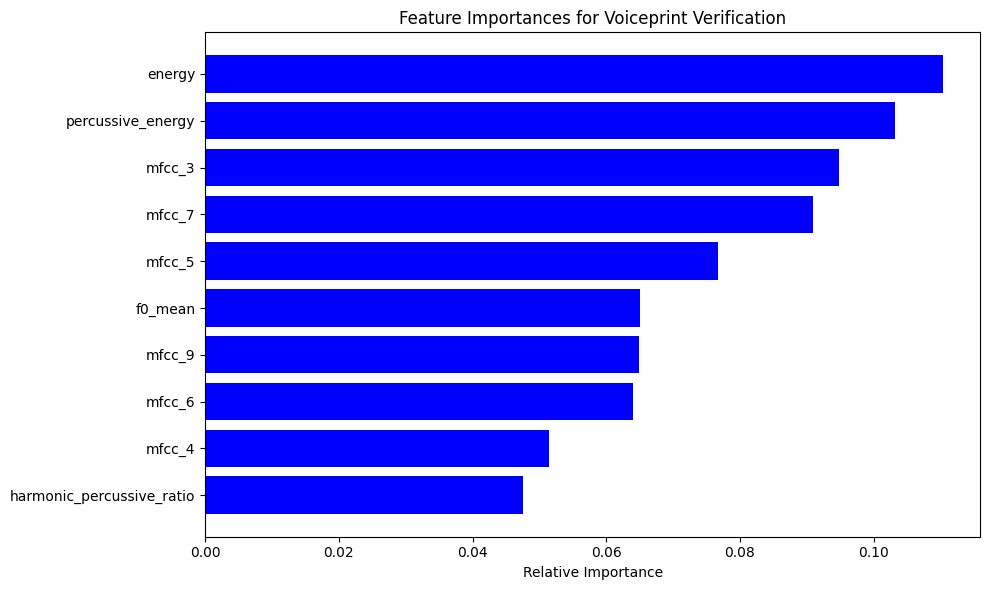


Top 5 most important features for voiceprint verification:
energy: 0.1104
percussive_energy: 0.1033
mfcc_3: 0.0949
mfcc_7: 0.0910
mfcc_5: 0.0768

Voiceprint verification model training complete!

A predict_voiceprint() function has been created for making predictions with the model


In [ ]:
# Build and evaluate a voiceprint verification model using K-fold CV instead of train/val/test splitting

# Import additional libraries needed for neural network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score

# Load features from the expanded dataset
print("Loading features from expanded dataset...")
try:
    df = pd.read_csv('../data/tables/audio_features.csv')
    print(f"Loaded dataset with {len(df)} samples")
except FileNotFoundError:
    # Fall back to original features if expanded not found
    print("Expanded features not found, falling back to original features...")
    df = pd.read_csv('../data/tables/audio_features.csv')
    if 'augmentation_intensity' not in df.columns:
        df['augmentation_intensity'] = 'unknown'
    print(f"Loaded fallback dataset with {len(df)} samples")

# Extract speaker label from filename
df['label'] = df['filename'].apply(lambda x: x.split('_')[0])

# Define person-to-customer-id mapping similar to face recognition model
print("\nCreating person-to-customer-id mapping...")
person_to_customer_id = {
    'owen': 187,
    'nicolas': 177,
    'abiodun': 189,
    'gaius': 120,
    'anissa': 103
}

# Fix any potential naming inconsistencies in the data
if 'gauis' in df['label'].unique():
    print("Fixing 'gauis' to 'gaius' in labels")
    df['label'] = df['label'].replace('gauis', 'gaius')

# Load customer data for validation
try:
    customer_df = pd.read_csv('../data/tables/merged_customer_data.csv')
    print(f"Loaded customer data with {len(customer_df)} records")
    
    # Create a set of valid customer IDs
    valid_customer_ids = set(customer_df['customer_id'].unique())
    
    # Validate and update mapping if needed
    for person, cid in person_to_customer_id.items():
        if cid not in valid_customer_ids:
            print(f"Warning: Customer ID {cid} for {person} not found in customer data")
            
except FileNotFoundError:
    print("Customer data file not found, using predefined mappings")

# Create a mapping dataframe and add customer IDs to the main dataset
df['customer_id'] = df['label'].map(person_to_customer_id)

# Check for NaN values in customer_id column
if df['customer_id'].isna().any():
    print(f"Warning: {df['customer_id'].isna().sum()} samples have NaN customer IDs")
    print("These speakers may not be mapped correctly:", df[df['customer_id'].isna()]['label'].unique())
    # Fill NaN values with a default value or remove those samples
    # Option 1: Remove samples with NaN customer IDs
    df = df.dropna(subset=['customer_id'])
    print(f"Removed samples with NaN customer IDs, {len(df)} samples remaining")
    # Option 2 (alternative): Fill with a default value
    # df['customer_id'] = df['customer_id'].fillna(-1)  # Use -1 to indicate unknown

# Convert customer_id to integer
df['customer_id'] = df['customer_id'].astype(int)

print("\nFixing data leakage by using GroupKFold for cross-validation...")

# Get unique files and their labels
unique_files = df['filename'].unique()
file_labels = {filename: df[df['filename'] == filename]['label'].iloc[0] for filename in unique_files}
file_customer_ids = {filename: df[df['filename'] == filename]['customer_id'].iloc[0] for filename in unique_files}

# Create file-to-label mapping DataFrame
file_df = pd.DataFrame({
    'filename': unique_files,
    'label': [file_labels[f] for f in unique_files],
    'customer_id': [file_customer_ids[f] for f in unique_files]
})

print(f"Number of unique files: {len(unique_files)}")
print(f"Number of unique speakers: {file_df['label'].nunique()}")
print(f"Number of unique customer IDs: {file_df['customer_id'].nunique()}")

# Count files per speaker
speaker_counts = file_df['label'].value_counts()
print("\nFiles per speaker:")
for speaker, count in speaker_counts.items():
    expected_customer_id = person_to_customer_id.get(speaker, "Unknown")
    actual_customer_id = file_df[file_df['label'] == speaker]['customer_id'].iloc[0]
    print(f"{speaker}: {count} files (Customer ID: {actual_customer_id})")

# Select features and prepare data
feature_cols = [col for col in df.columns if col not in ['filename', 'augmentation', 'augmentation_intensity', 'label', 'customer_id']]
X = df[feature_cols]
y_speaker = df['label']
y_customer = df['customer_id']

# Create GroupKFold with groups based on filename to prevent data leakage
groups = df['filename']
n_splits = min(5, len(unique_files))  # Use 5-fold CV or fewer if we have fewer files
gkf = GroupKFold(n_splits=n_splits)

# Ensure consistent label encoding for speakers
label_encoder = LabelEncoder().fit(y_speaker)
y_speaker_encoded = label_encoder.transform(y_speaker)
speaker_names = label_encoder.classes_

# Create a separate encoder for customer IDs
customer_encoder = LabelEncoder().fit(y_customer)
y_customer_encoded = customer_encoder.transform(y_customer)
customer_id_names = customer_encoder.classes_

print(f"\nUsing {n_splits}-fold GroupKFold cross-validation to prevent data leakage")
print(f"This ensures that augmentations from the same file stay in the same fold")
print(f"Speaker names: {speaker_names}")
print(f"Customer IDs: {customer_id_names}")

# Apply normalization and feature selection in each fold to prevent data leakage
fold_metrics = []
best_models = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y_speaker_encoded, groups)):
    print(f"\n--- Fold {fold_idx + 1}/{n_splits} ---")
    
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_speaker, y_test_speaker = y_speaker_encoded[train_idx], y_speaker_encoded[test_idx]
    y_train_customer, y_test_customer = y_customer_encoded[train_idx], y_customer_encoded[test_idx]
    
    # Check file distribution
    train_files = df.iloc[train_idx]['filename'].unique()
    test_files = df.iloc[test_idx]['filename'].unique()
    print(f"Training on {len(train_files)} files, testing on {len(test_files)} files")
    
    # Check speaker distribution
    train_speakers = df.iloc[train_idx]['label'].unique()
    test_speakers = df.iloc[test_idx]['label'].unique()
    print(f"Training speakers: {sorted(train_speakers)}")
    print(f"Testing speakers: {sorted(test_speakers)}")
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Check for highly correlated features
    correlation_matrix = X_train.corr().abs()
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    if high_corr_features:
        print(f"Removing {len(high_corr_features)} highly correlated features")
        # Create a reduced feature set
        reduced_feature_cols = [col for col in feature_cols if col not in high_corr_features]
        X_train_reduced = X_train[reduced_feature_cols]
        X_test_reduced = X_test[reduced_feature_cols]
        
        # Re-scale with reduced features
        scaler_reduced = StandardScaler()
        X_train_scaled = scaler_reduced.fit_transform(X_train_reduced)
        X_test_scaled = scaler_reduced.transform(X_test_reduced)
        
        current_feature_cols = reduced_feature_cols
    else:
        current_feature_cols = feature_cols
    
    # Train and evaluate models
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=2,
            min_samples_leaf=1,
            bootstrap=True,
            class_weight='balanced',
            random_state=42
        ),
        'NeuralNetwork': MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size='auto',
            learning_rate='adaptive',
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        )
    }
    
    # Evaluate each model (for speaker identification - maintaining original functionality)
    fold_model_metrics = {}
    for name, model in models.items():
        print(f"\nTraining {name} for speaker identification...")
        model.fit(X_train_scaled, y_train_speaker)
        
        # Make predictions for speaker
        y_pred_speaker = model.predict(X_test_scaled)
        
        # Fixed log_loss calculation with proper error handling
        loss = None
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)
            try:
                # Get unique classes in this test fold
                classes_in_test = np.unique(y_test_speaker)
                
                # If we don't have all classes in the test set, we need to handle it specially
                if len(classes_in_test) < len(label_encoder.classes_):
                    print(f"Warning: Test fold only contains {len(classes_in_test)} out of {len(label_encoder.classes_)} classes")
                    print(f"Classes in test fold: {classes_in_test}")
                    
                    # Create a mapping from original class indices to test fold indices
                    test_class_mask = np.isin(np.arange(len(label_encoder.classes_)), classes_in_test)
                    
                    # Filter probabilities to only include classes in the test set
                    y_proba_subset = y_proba[:, test_class_mask]
                    
                    # Calculate log loss with explicit labels
                    loss = log_loss(y_test_speaker, y_proba_subset, labels=classes_in_test)
                else:
                    # Normal case: all classes are present
                    loss = log_loss(y_test_speaker, y_proba)
            except Exception as e:
                print(f"Warning: Could not calculate log loss: {e}")
                loss = None
        
        # Calculate metrics for speaker identification
        acc_speaker = accuracy_score(y_test_speaker, y_pred_speaker)
        f1_speaker = f1_score(y_test_speaker, y_pred_speaker, average='weighted')
        
        # Now test customer ID prediction (based on the speaker identification)
        # Map predicted speakers to customer IDs
        predicted_speakers = label_encoder.inverse_transform(y_pred_speaker)
        y_pred_customer = np.array([person_to_customer_id.get(speaker, -1) for speaker in predicted_speakers])
        
        # Map to encoded customer IDs for evaluation
        actual_customer_ids = customer_encoder.inverse_transform(y_test_customer)
        
        # Direct comparison of customer IDs
        customer_accuracy = np.mean(y_pred_customer == actual_customer_ids)
        
        print(f"{name} - Speaker Accuracy: {acc_speaker:.3f}, F1: {f1_speaker:.3f}")
        print(f"{name} - Customer ID Accuracy: {customer_accuracy:.3f}")
        if loss is not None:
            print(f"{name} - Log Loss: {loss:.3f}")
        
        fold_model_metrics[name] = {
            'model': model,
            'accuracy': acc_speaker,  # Keep using speaker accuracy as primary metric
            'f1': f1_speaker,
            'customer_accuracy': customer_accuracy,
            'log_loss': loss,
            'scaler': scaler,
            'feature_cols': current_feature_cols
        }
    
    # Select best model for this fold (still based on speaker accuracy to maintain original behavior)
    best_model_name = max(fold_model_metrics, key=lambda name: fold_model_metrics[name]['accuracy'])
    best_model_data = fold_model_metrics[best_model_name]
    print(f"Best model for fold {fold_idx + 1}: {best_model_name} (Speaker Accuracy: {best_model_data['accuracy']:.3f}, Customer Accuracy: {best_model_data['customer_accuracy']:.3f})")
    
    fold_metrics.append({
        'fold': fold_idx + 1,
        'best_model': best_model_name,
        'accuracy': best_model_data['accuracy'],
        'f1': best_model_data['f1'],
        'customer_accuracy': best_model_data['customer_accuracy'],
        'log_loss': best_model_data['log_loss']
    })
    
    best_models.append({
        'fold': fold_idx + 1,
        'model_name': best_model_name,
        'model': best_model_data['model'],
        'scaler': best_model_data['scaler'],
        'feature_cols': best_model_data['feature_cols'],
        'accuracy': best_model_data['accuracy'],
        'f1': best_model_data['f1'],
        'customer_accuracy': best_model_data['customer_accuracy']
    })

# Display overall cross-validation results
print("\n--- Cross-Validation Results ---")
metrics_df = pd.DataFrame(fold_metrics)
print(f"Average Speaker Accuracy: {metrics_df['accuracy'].mean():.3f} ± {metrics_df['accuracy'].std():.3f}")
print(f"Average F1-Score: {metrics_df['f1'].mean():.3f} ± {metrics_df['f1'].std():.3f}")
print(f"Average Customer ID Accuracy: {metrics_df['customer_accuracy'].mean():.3f} ± {metrics_df['customer_accuracy'].std():.3f}")
if not metrics_df['log_loss'].isnull().all():
    print(f"Average Log Loss: {metrics_df['log_loss'].mean():.3f} ± {metrics_df['log_loss'].std():.3f}")

# Find the best model across all folds
best_fold_idx = metrics_df['accuracy'].idxmax()
best_fold = metrics_df.loc[best_fold_idx]
print(f"\nBest model from fold {best_fold['fold']}: {best_fold['best_model']} (Speaker Accuracy: {best_fold['accuracy']:.3f}, Customer Accuracy: {best_fold['customer_accuracy']:.3f})")

# Get the actual best model
best_model_data = best_models[best_fold_idx]

# Train a final model on all data using the best configuration
print("\n--- Training Final Model on All Data ---")
final_model = models[best_model_data['model_name']]
final_scaler = StandardScaler()

# Scale all features
X_all_scaled = final_scaler.fit_transform(df[best_model_data['feature_cols']])
y_all = label_encoder.transform(df['label'])

# Train final model
final_model.fit(X_all_scaled, y_all)

# Analyze impact of different augmentations on model performance using cross-validation predictions
print("\n--- Analyzing Impact of Augmentations ---")

# Group data by augmentation type
aug_types = df['augmentation'].unique()
aug_results = []

# Analyze each augmentation type using the best model configuration
for aug in aug_types:
    df_aug = df[df['augmentation'] == aug]
    if len(df_aug) == 0:
        continue
        
    X_aug = df_aug[best_model_data['feature_cols']]
    y_aug = label_encoder.transform(df_aug['label'])
    X_aug_scaled = final_scaler.transform(X_aug)
    
    # Use the final model for consistent evaluation
    y_pred_aug = final_model.predict(X_aug_scaled)
    aug_acc = accuracy_score(y_aug, y_pred_aug)
    aug_f1 = f1_score(y_aug, y_pred_aug, average='weighted')
    
    aug_results.append({
        'augmentation': aug,
        'accuracy': aug_acc,
        'f1_score': aug_f1,
        'count': len(df_aug)
    })
    
    print(f"Accuracy on {aug} data ({len(df_aug)} samples): {aug_acc:.3f}, F1: {aug_f1:.3f}")

# Save the final model
import joblib
model_output_dir = '../models'
os.makedirs(model_output_dir, exist_ok=True)

# Save model components
joblib.dump(final_model, f'{model_output_dir}/voiceprint_verification_model.pkl')
joblib.dump(final_scaler, f'{model_output_dir}/voiceprint_scaler.pkl')
joblib.dump(label_encoder, f'{model_output_dir}/voiceprint_label_encoder.pkl')
joblib.dump(best_model_data['feature_cols'], f'{model_output_dir}/voiceprint_feature_columns.pkl')

# Save additional mapping for customer IDs
joblib.dump(person_to_customer_id, f'{model_output_dir}/voiceprint_person_to_customer.pkl')

# Save model metadata
model_metadata = {
    'model_type': best_model_data['model_name'],
    'feature_count': len(best_model_data['feature_cols']),
    'cross_validation_folds': n_splits,
    'avg_accuracy': float(metrics_df['accuracy'].mean()),
    'avg_f1': float(metrics_df['f1'].mean()),
    'avg_customer_accuracy': float(metrics_df['customer_accuracy'].mean()),
    'best_fold_accuracy': float(best_fold['accuracy']),
    'speakers': list(speaker_names),
    'customer_ids': {speaker: int(person_to_customer_id.get(speaker, -1)) for speaker in speaker_names},
    'augmentation_types': list(aug_types),
    'datetime': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
}

with open(f'{model_output_dir}/voiceprint_model_metadata.json', 'w') as f:
    import json
    json.dump(model_metadata, f, indent=2)

print(f"\nModel and components saved to {model_output_dir}/")
print(f"  - Model: voiceprint_verification_model.pkl")
print(f"  - Scaler: voiceprint_scaler.pkl")
print(f"  - Label encoder: voiceprint_label_encoder.pkl")
print(f"  - Feature columns: voiceprint_feature_columns.pkl")
print(f"  - Person to customer mapping: voiceprint_person_to_customer.pkl")
print(f"  - Model metadata: voiceprint_model_metadata.json")


# Feature importance for Random Forest model
if best_model_data['model_name'] == 'RandomForest' and hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_cols = best_model_data['feature_cols']
    indices = np.argsort(importances)[-10:]  # Top 10 features
    feature_names = np.array(feature_cols)[indices]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances for Voiceprint Verification')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), feature_names)
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

    # Print the top 5 most important features
    top_features = [(feature_cols[i], importances[i]) for i in np.argsort(importances)[::-1][:5]]
    print("\nTop 5 most important features for voiceprint verification:")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")

print("\nVoiceprint verification model training complete!")

# Function to predict both speaker and customer ID for a new audio sample
def predict_voiceprint(audio_features, return_probabilities=False):
    """
    Predict speaker and customer ID from audio features
    
    Parameters:
    -----------
    audio_features : dict or array-like
        Audio features extracted from an audio sample
    return_probabilities : bool, default=False
        Whether to return prediction probabilities
        
    Returns:
    --------
    dict
        Contains predicted speaker, customer_id and optionally probabilities
    """
    # Convert features to correct format if needed
    if isinstance(audio_features, dict):
        # Extract only the features used in the model
        feature_values = [audio_features.get(col, 0) for col in best_model_data['feature_cols']]
        features = np.array(feature_values).reshape(1, -1)
    else:
        features = np.array(audio_features).reshape(1, -1)
    
    # Scale features
    scaled_features = final_scaler.transform(features)
    
    # Predict speaker
    speaker_pred = final_model.predict(scaled_features)[0]
    speaker_name = label_encoder.inverse_transform([speaker_pred])[0]
    
    # Map speaker to customer ID
    customer_id = person_to_customer_id.get(speaker_name, -1)
    
    result = {
        'speaker': speaker_name,
        'customer_id': customer_id
    }
    
    # Add probabilities if requested
    if return_probabilities and hasattr(final_model, 'predict_proba'):
        proba = final_model.predict_proba(scaled_features)[0]
        result['speaker_probabilities'] = {
            label_encoder.inverse_transform([i])[0]: float(proba[i])
            for i in range(len(proba))
        }
        
    return result

print("\nA predict_voiceprint() function has been created for making predictions with the model")